In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

In [105]:
import pandas as pd

In [106]:
import numpy as np
import random
import os
import gc

from sklearn.preprocessing import LabelEncoder

In [107]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [108]:
train = pd.read_csv('flight/train.csv')
test = pd.read_csv('flight/test.csv')
sample_submission = pd.read_csv('flight/sample_submission.csv')

                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006   0.109006
Carrier_Code(IATA)        108993   0.108993
Estimated_Departure_Time  108984   0.108984
Airline                   106527   0.106527
Destination_State         106523   0.106523
Origin_State              106505   0.106505
Destination_Airport            0   0.000000
Distance                       0   0.000000
Destination_Airport_ID         0   0.000000
ID                             0   0.000000
Month                          0   0.000000
Origin_Airport_ID              0   0.000000
Origin_Airport                 0   0.000000
Diverted                       0   0.000000
Cancelled                      0   0.000000
Day_of_Month                   0   0.000000
Tail_Number                    0   0.000000
                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040

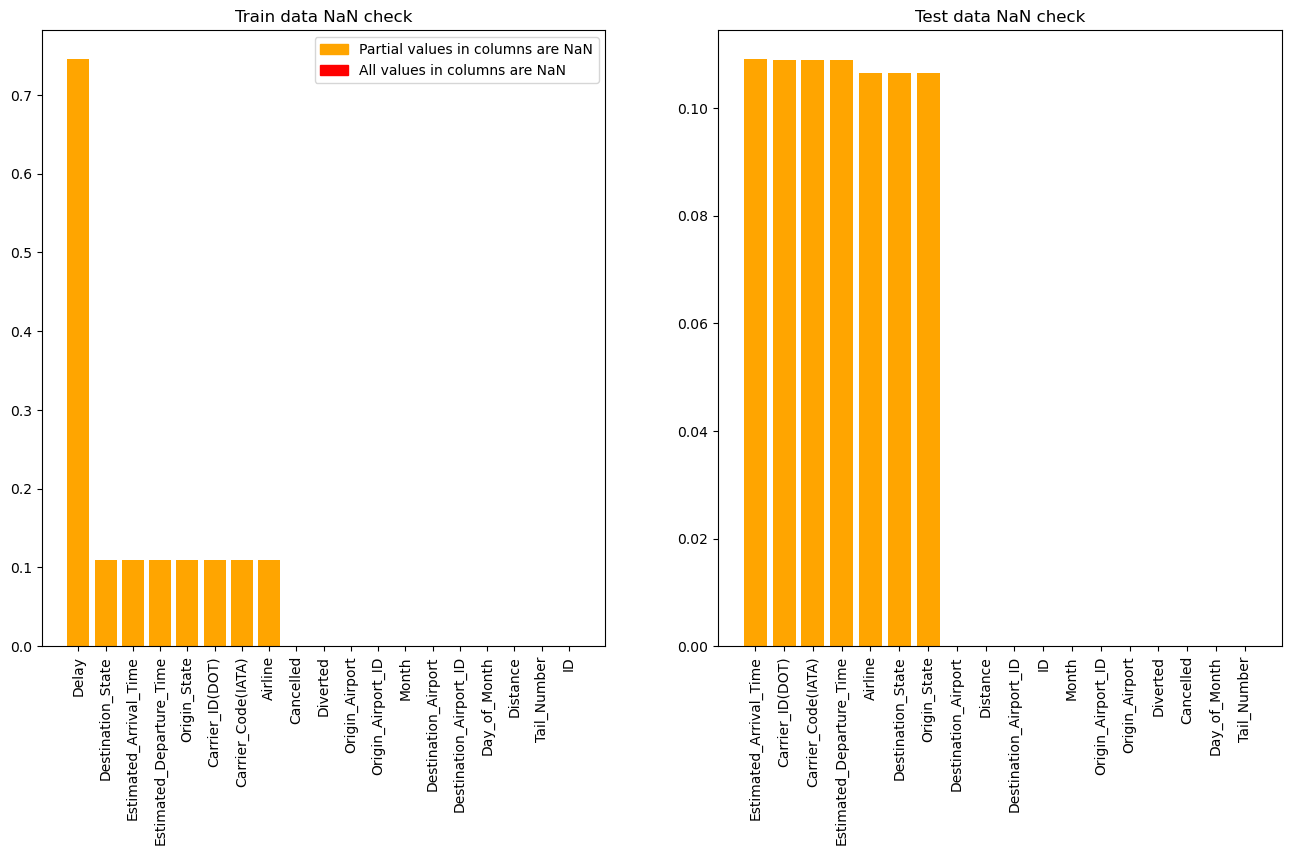

In [109]:
import matplotlib

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(test_row_NaN)
print(train_row_NaN)
plt.show()

기존 train 데이터로 self training을 진행하여 null이 있는 열을 학습시켜야함.
순서는 null이 적은 값부터 많은 순서대로 학습 <br>
Airline > Carrier_ID(DOT) > Carrier_Code(IATA) > Estimated_Departure_Time > Estimated_Arrival_Time > delay <br>  

In [110]:
import datetime
def to_time(time_list):
    Time = pd.Series(time_list).astype(str).str.zfill(4)
    Time = Time.replace('2400','0000')
    return [datetime.datetime.strptime(i, '%H%M').strftime("%H:%M") if i != '0nan' else np.NaN for i in Time] 

time_list = [i if str(i) == 'nan' else str(int(i))  for i in train['Estimated_Departure_Time'] ]
time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in train['Estimated_Arrival_Time'] ]
train['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
train['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)
train

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,...,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN,NaN,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,...,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN,07:40,10:24
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,...,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN,16:10,18:05
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,...,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN,09:05,17:35
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,...,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN,09:00,10:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,ORD,13930,NaN,...,14100,NaN,678.0,United Air Lines Inc.,UA,19977.0,N477UA,NaN,09:36,12:43
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,FAR,11637,NaN,...,13487,Minnesota,223.0,SkyWest Airlines Inc.,DL,NaN,N439SW,NaN,09:20,10:28
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,NaN,...,12191,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,NaN,08:00,13:40
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,...,10397,NaN,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,NaN,16:13,18:24


In [111]:
time_list = [i if str(i) == 'nan' else str(int(i))  for i in test['Estimated_Departure_Time'] ]
time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in test['Estimated_Arrival_Time'] ]

test['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
test['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)

In [112]:
train['Estimated_Departure_HH'] = [int(i.split(':')[0]) if str(i) != 'nan' else np.NaN for i in train['Estimated_Departure_Time_HH:MM']]
train['Estimated_Departure_MM'] = [int(i.split(':')[1]) if str(i) != 'nan' else np.NaN for i in train['Estimated_Departure_Time_HH:MM']]

train['Estimated_Arrival_HH'] = [int(i.split(':')[0]) if str(i) != 'nan' else np.NaN for i in train['Estimated_Arrival_Time_HH:MM']]
train['Estimated_Arrival_MM'] = [int(i.split(':')[1]) if str(i) != 'nan' else np.NaN for i in train['Estimated_Arrival_Time_HH:MM']]
train

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Estimated_Departure_HH,Estimated_Departure_MM,Estimated_Arrival_HH,Estimated_Arrival_MM
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,...,WN,19393.0,N7858A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,...,UA,20304.0,N125SY,NaN,07:40,10:24,7.0,40.0,10.0,24.0
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,...,AA,19805.0,N103US,NaN,16:10,18:05,16.0,10.0,18.0,5.0
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,...,UA,NaN,N595UA,NaN,09:05,17:35,9.0,5.0,17.0,35.0
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,...,UA,20304.0,N161SY,NaN,09:00,10:19,9.0,0.0,10.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,ORD,13930,NaN,...,UA,19977.0,N477UA,NaN,09:36,12:43,9.0,36.0,12.0,43.0
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,FAR,11637,NaN,...,DL,NaN,N439SW,NaN,09:20,10:28,9.0,20.0,10.0,28.0
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,NaN,...,WN,19393.0,N230WN,NaN,08:00,13:40,8.0,0.0,13.0,40.0
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,...,DL,19790.0,N968DL,NaN,16:13,18:24,16.0,13.0,18.0,24.0


In [113]:
test['Estimated_Departure_HH'] = [int(i.split(':')[0]) if str(i) != 'nan' else np.NaN for i in test['Estimated_Departure_Time_HH:MM']]
test['Estimated_Departure_MM'] = [int(i.split(':')[1]) if str(i) != 'nan' else np.NaN for i in test['Estimated_Departure_Time_HH:MM']]

test['Estimated_Arrival_HH'] = [int(i.split(':')[0]) if str(i) != 'nan' else np.NaN for i in test['Estimated_Arrival_Time_HH:MM']]
test['Estimated_Arrival_MM'] = [int(i.split(':')[1]) if str(i) != 'nan' else np.NaN for i in test['Estimated_Arrival_Time_HH:MM']]

In [114]:
def state(t):
	# State 채우기
	# 값이 없는 특정 State 채우기
	origin_state = train[['Origin_Airport','Origin_Airport_ID','Origin_State']].dropna()
	origin_state = origin_state.drop_duplicates()
	origin_state.columns = ['Origin_Airport','Origin_Airport_ID','F_Origin_State']
	Destination_state = train[['Destination_Airport','Destination_Airport_ID','Destination_State']].dropna()
	Destination_state = Destination_state.drop_duplicates()
	Destination_state.columns = ['Destination_Airport','Destination_Airport_ID','F_Destination_State']

	t = pd.merge(t, origin_state, how='left', on=['Origin_Airport','Origin_Airport_ID'], sort=False)
	t = pd.merge(t, Destination_state, how='left', on=['Destination_Airport','Destination_Airport_ID'], sort=False)
	

	mask = (t['Destination_Airport'] == 'YNG')&(t['Destination_Airport_ID'] == 16133)
	value = 'Indiana'
	t.loc[mask,'F_Destination_State'] = t.loc[mask,'F_Destination_State'].fillna(value) 
	t = t.drop(columns=['Origin_State', 'Destination_State'])
	t = t.rename(columns={'F_Origin_State': 'Origin_State', 'F_Destination_State': 'Destination_State'})
	return t

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import OrdinalEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

train_lb = state(train_lb)
test_lb = state(test_lb)

fill_list = ['Origin_State', 'Destination_State', 'Airline', 'Carrier_ID(DOT)','Carrier_Code(IATA)','Estimated_Departure_HH','Estimated_Departure_MM', 'Estimated_Arrival_HH','Estimated_Arrival_MM','Delay']
not_labeling_list = ['Carrier_ID(DOT)','Estimated_Departure_HH','Estimated_Departure_MM', 'Estimated_Arrival_HH','Estimated_Arrival_MM']

qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']
oridinary_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Destination_Airport', 'Destination_Airport_ID', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

# Train 데이터에서 null이 없는 열들 중 라벨링(not int)이 필요한 열들 순차적으로 정리
add_list = {}
for i in range(len(fill_list)): 
    if i == 0:
        add_list[i] = qual_col
    else:       
        add_list[i] = add_list[i-1] + [fill_list[i-1]]
        add_list[i] = list(set(add_list[i]) - set(not_labeling_list))

add_list

for i in range(len(fill_list)): 
    # 라벨링 준비
    label_st = train_lb.drop(columns = [fill_list[i]])
    train_st = train_lb[(train_lb[fill_list[i]].astype(str) != 'None')&(train_lb[fill_list[i]].astype(str) != 'nan')].drop(columns = [fill_list[i]])
    X_nan = train_lb[(train_lb[fill_list[i]].astype(str) == 'None')|(train_lb[fill_list[i]].astype(str) == 'nan')].drop(columns = [fill_list[i]])
    if fill_list[i] != 'Delay':
        if fill_list[i] == 'Origin_State':
            test_nan = test_lb[(test_lb[fill_list[i]].astype(str) == 'None')|(test_lb[fill_list[i]].astype(str) == 'nan')].drop(columns = [fill_list[i]])
        else:
            test_nan = test_lb[(test_lb[fill_list[i]].astype(str) == 'None')|(test_lb[fill_list[i]].astype(str) == 'nan')].drop(columns = [fill_list[i]]).dropna(subset = [fill_list[i-1]])
    else:
        pass
    print('시작 리스트: ',add_list[i])
    print('채워야하는 열: ',fill_list[i])
    
    # 라벨링이 안된 원소들 라벨링
    for j in add_list[i]:
        # train에는 없고, test에는 있는 원소는 -2 처리
        oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
        oe=oe.fit(label_st[j].to_numpy().reshape(-1, 1))
        train_st[j]=oe.transform(train_st[j].to_numpy().reshape(-1, 1))
        
        if X_nan[j].isna().sum() != 0:
            X_nan[j]=oe.transform(X_nan[j].to_numpy().reshape(-1, 1))
        else:
            pass
        if fill_list[i] != 'Delay':
            test_nan[j]= oe.transform(test_nan[j].to_numpy().reshape(-1, 1))
        else:
            pass

    # 라벨링을 통해 null이 없었던 columns을 통해서 self_training
    X = train_st[oridinary_col]
    target_col = oridinary_col+ [fill_list[i]]
    y = train_lb[(train_lb[fill_list[i]].astype(str) != 'None')&(train_lb[fill_list[i]].astype(str) != 'nan')][target_col][fill_list[i]]

    stclf = SelfTrainingClassifier(
        base_estimator = RandomForestClassifier(n_estimators = 100, random_state=113),
        verbose = True)
    stclf.fit(X, y)   

    # 결과값 삽입
    if fill_list[i] == 'Origin_State':
        pass
    else:
        if len(X_nan[fill_list[i-1]]) != 0:
            X_nan[fill_list[i]+'_pred'] = stclf.predict(X_nan[oridinary_col])
        else:
            pass
        
    if fill_list[i] != 'Delay':
        test_nan[fill_list[i]+'_pred'] = stclf.predict(test_nan[oridinary_col])
    else:    
        pass
    if fill_list[i] == 'Origin_State':
        pass
    else:
        if len(X_nan[fill_list[i-1]]) != 0:
            train_lb.loc[(train_lb[fill_list[i]].astype(str) == 'None')|(train_lb[fill_list[i]].astype(str) == 'nan'), fill_list[i]] = X_nan[fill_list[i]+'_pred']
        else:    
            pass
    
    if fill_list[i] != 'Delay':
        test_lb.loc[(test_lb[fill_list[i]].astype(str) == 'None')|(test_lb[fill_list[i]].astype(str) ==  'nan'), fill_list[i]] = test_nan[fill_list[i]+'_pred']
    else:    
        pass
    
    # 다음 self_training을 위해 열 변경
    oridinary_col = oridinary_col + [fill_list[i]]
    print('다음 훈련 리스트: ', oridinary_col)


시작 리스트:  ['Origin_Airport', 'Destination_Airport', 'Tail_Number']
채워야하는 열:  Origin_State


/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


다음 훈련 리스트:  ['Cancelled', 'Diverted', 'Origin_Airport', 'Origin_Airport_ID', 'Destination_Airport', 'Destination_Airport_ID', 'Tail_Number', 'Month', 'Day_of_Month', 'Distance', 'Origin_State']
시작 리스트:  ['Origin_Airport', 'Destination_Airport', 'Origin_State', 'Tail_Number']
채워야하는 열:  Destination_State


/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


다음 훈련 리스트:  ['Cancelled', 'Diverted', 'Origin_Airport', 'Origin_Airport_ID', 'Destination_Airport', 'Destination_Airport_ID', 'Tail_Number', 'Month', 'Day_of_Month', 'Distance', 'Origin_State', 'Destination_State']
시작 리스트:  ['Destination_Airport', 'Origin_State', 'Tail_Number', 'Origin_Airport', 'Destination_State']
채워야하는 열:  Airline


/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [150]:
len(X_nan[fill_list[i-1]])

KeyError: 'Destination_State'

In [ ]:
train_lb.to_csv(os.path.join(file_dir,'train_lb.csv'), index=False,encoding="utf-8-sig")
test_lb.to_csv(os.path.join(file_dir,'test_lb.csv'), index=False,encoding="utf-8-sig")

In [30]:
train = pd.read_csv('flight/train_lb.csv')
test = pd.read_csv('flight/test_lb.csv')
sample_submission = pd.read_csv('flight/sample_submission.csv')

In [4]:
train = train_lb
test = test_lb

NameError: name 'train_lb' is not defined

In [31]:
train

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Estimated_Departure_HH,Estimated_Departure_MM,Estimated_Arrival_HH,Estimated_Arrival_MM
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,...,WN,19393.0,N7858A,Not_Delayed,NaN,NaN,14.0,55.0,16.0,20.0
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,...,UA,20304.0,N125SY,Not_Delayed,07:40,10:24,7.0,40.0,10.0,24.0
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,...,AA,19805.0,N103US,Not_Delayed,16:10,18:05,16.0,10.0,18.0,5.0
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,...,UA,19977.0,N595UA,Not_Delayed,09:05,17:35,9.0,5.0,17.0,35.0
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,...,UA,20304.0,N161SY,Not_Delayed,09:00,10:19,9.0,0.0,10.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,ORD,13930,Illinois,...,UA,19977.0,N477UA,Not_Delayed,09:36,12:43,9.0,36.0,12.0,43.0
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,FAR,11637,North Dakota,...,DL,20304.0,N439SW,Not_Delayed,09:20,10:28,9.0,20.0,10.0,28.0
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,California,...,WN,19393.0,N230WN,Not_Delayed,08:00,13:40,8.0,0.0,13.0,40.0
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,...,DL,19790.0,N968DL,Not_Delayed,16:13,18:24,16.0,13.0,18.0,24.0


In [32]:
train = train.drop(columns = ['Estimated_Departure_Time','Estimated_Arrival_Time','Estimated_Departure_Time_HH:MM', 'Estimated_Arrival_Time_HH:MM'])
train['Estimated_Departure_Time'] = [int(str(int(i)) + str(int(j))) for i, j in zip(train['Estimated_Departure_HH'], train['Estimated_Departure_MM'])]
train['Estimated_Arrival_Time'] = [int(str(int(i)) + str(int(j))) for i, j in zip(train['Estimated_Arrival_HH'], train['Estimated_Arrival_MM'])]
train

,ID,Month,Day_of_Month,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_HH,Estimated_Departure_MM,Estimated_Arrival_HH,Estimated_Arrival_MM,Estimated_Departure_Time,Estimated_Arrival_Time
0,TRAIN_000000,4,15,0,0,OKC,13851,Oklahoma,HOU,12191,...,WN,19393.0,N7858A,Not_Delayed,14.0,55.0,16.0,20.0,1455,1620
1,TRAIN_000001,8,15,0,0,ORD,13930,Illinois,SLC,14869,...,UA,20304.0,N125SY,Not_Delayed,7.0,40.0,10.0,24.0,740,1024
2,TRAIN_000002,9,6,0,0,CLT,11057,North Carolina,LGA,12953,...,AA,19805.0,N103US,Not_Delayed,16.0,10.0,18.0,5.0,1610,185
3,TRAIN_000003,7,10,0,0,LAX,12892,California,EWR,11618,...,UA,19977.0,N595UA,Not_Delayed,9.0,5.0,17.0,35.0,95,1735
4,TRAIN_000004,1,11,0,0,SFO,14771,California,ACV,10157,...,UA,20304.0,N161SY,Not_Delayed,9.0,0.0,10.0,19.0,90,1019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,0,0,ORD,13930,Illinois,PHL,14100,...,UA,19977.0,N477UA,Not_Delayed,9.0,36.0,12.0,43.0,936,1243
999996,TRAIN_999996,5,30,0,0,FAR,11637,North Dakota,MSP,13487,...,DL,20304.0,N439SW,Not_Delayed,9.0,20.0,10.0,28.0,920,1028
999997,TRAIN_999997,6,28,0,0,OAK,13796,California,HOU,12191,...,WN,19393.0,N230WN,Not_Delayed,8.0,0.0,13.0,40.0,80,1340
999998,TRAIN_999998,9,27,0,0,BNA,10693,Tennessee,ATL,10397,...,DL,19790.0,N968DL,Not_Delayed,16.0,13.0,18.0,24.0,1613,1824


In [33]:
test = test.drop(columns = ['Estimated_Departure_Time','Estimated_Arrival_Time','Estimated_Departure_Time_HH:MM', 'Estimated_Arrival_Time_HH:MM'])
test['Estimated_Departure_Time'] = [int(str(int(i)) + str(int(j))) for i, j in zip(test['Estimated_Departure_HH'], test['Estimated_Departure_MM'])]
test['Estimated_Arrival_Time'] = [int(str(int(i)) + str(int(j))) for i, j in zip(test['Estimated_Arrival_HH'], test['Estimated_Arrival_MM'])]
test

,ID,Month,Day_of_Month,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Estimated_Departure_HH,Estimated_Departure_MM,Estimated_Arrival_HH,Estimated_Arrival_MM,Estimated_Departure_Time,Estimated_Arrival_Time
0,TEST_000000,12,16,0,0,IAH,12266,Texas,SAT,14683,...,United Air Lines Inc.,UA,19977.0,N79402,11.0,56.0,12.0,54.0,1156,1254
1,TEST_000001,9,12,0,0,EWR,11618,New Jersey,ATL,10397,...,Delta Air Lines Inc.,DL,19790.0,N3765,15.0,0.0,17.0,15.0,150,1715
2,TEST_000002,3,6,0,0,ORD,13930,Illinois,LGA,12953,...,United Air Lines Inc.,UA,19977.0,N413UA,16.0,0.0,19.0,15.0,160,1915
3,TEST_000003,5,18,0,0,OAK,13796,California,LAX,12892,...,Southwest Airlines Co.,WN,19393.0,N905WN,19.0,20.0,20.0,45.0,1920,2045
4,TEST_000004,7,7,0,0,FLL,11697,Florida,LAX,12892,...,JetBlue Airways,B6,20409.0,N945JT,19.0,15.0,21.0,52.0,1915,2152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TEST_999995,6,2,0,0,LAX,12892,California,DEN,11292,...,Southwest Airlines Co.,WN,19393.0,N720WN,6.0,0.0,22.0,40.0,60,2240
999996,TEST_999996,6,8,0,0,BUF,10792,New York,ORD,13930,...,United Air Lines Inc.,UA,19977.0,N401UA,6.0,0.0,6.0,48.0,60,648
999997,TEST_999997,6,11,0,0,IAD,12264,Virginia,DTW,11433,...,Mesa Airlines Inc.,UA,20378.0,N510MJ,17.0,10.0,19.0,7.0,1710,197
999998,TEST_999998,11,17,0,0,SAN,14679,California,BOS,10721,...,JetBlue Airways,B6,20409.0,N986JB,21.0,10.0,5.0,0.0,2110,50


In [34]:
import itertools
import pandas as pd
import datetime 
def feature_engineering(t):
	def to_time(time_list):
		Time = pd.Series(time_list).astype(str).str.zfill(4)
		Time = Time.replace('2400','0000')
		return Time
	time_list = [i if str(i) == 'nan' else str(int(i))  for i in t['Estimated_Departure_Time'] ]
	time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in t['Estimated_Arrival_Time'] ]
	
	def parse_times(val):
		val = val.strip()
		h, m = int(val[:2]), int(val[2:])
		if hrs:= m // 60>0:
			h += hrs
			m = m - hrs*60
		h = h%24
		return datetime.time(hour=h, minute=m).strftime('%H:%M')

	t['Estimated_Departure_Time_HH:MM'] = [parse_times(i) for i in to_time(time_list)] 
	t['Estimated_Arrival_Time_HH:MM'] = [parse_times(i) for i in to_time(time_list1)] 
	
	# 예상 비행시간 만들기 (분으로 만들기)
	est_time = []
	for i,j in zip(t['Estimated_Arrival_Time_HH:MM'], t['Estimated_Departure_Time_HH:MM']):
		if i != 'nan' and j != 'nan':
			if (datetime.datetime.strptime(i, "%H:%M") - datetime.datetime.strptime(j, "%H:%M")).total_seconds()/60 >= 0:
				est_time.append((datetime.datetime.strptime(i, "%H:%M") - datetime.datetime.strptime(j, "%H:%M")).total_seconds()/60)
			else:
				time = datetime.datetime.strptime(i, "%H:%M") - datetime.datetime.strptime(j, "%H:%M") + datetime.datetime.strptime('23:59', "%H:%M") + datetime.timedelta(minutes=1)
				est_time.append(datetime.timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60)
		else:
			est_time.append(np.NaN)
			
	# 예상 출발, 도착시간 그룹 화
	def time_gb(x):		
		if x >= 600 and x <= 659:
			return '0600-0659'
		elif x>=1400 and x<=1459:
			return '1400-1459'
		elif x>=1200 and x<=1259:
			return '1200-1259'
		elif x>=1500 and x<=1559:
			return '1500-1559'
		elif x>=1900 and x<=1959:
			return '1900-1959'
		elif x>=900 and x<=959:
			return '0900-0959'
		elif x>=1000 and x<=1059:
			return  '1000-1059'
		elif x>=2000 and x<=2059:
			return '2000-2059'
		elif x>=1300 and x<=1359:
			return '1300-1359'
		elif x>=1100 and x<=1159:
			return '1100-1159'
		elif x>=800 and x<=859:
			return '0800-0859'
		elif x>=2200 and x<=2259:
			return '2200-2259'
		elif x>=1600 and x<=1659:
			return '1600-1659'
		elif x>=1700 and x<=1759:
			return '1700-1759'
		elif x>=2100 and x<=2159:
			return '2100-2159'
		elif x>=700 and x<=759:
			return '0700-0759'
		elif x>=1800 and x<=1859:
			return '1800-1859'
		elif x>=1 and x<=559:
			return '0001-0559'
		elif x>=2300 and x<=2400:
			return '2300-2400'
		else:
			return 'dummy'

	t['Dep_time_gb'] = t['Estimated_Departure_Time'].dropna().apply(time_gb)
	t['Arr_time_gb'] = t['Estimated_Arrival_Time'].dropna().apply(time_gb)
	
	# 예상 출발, 도착시간 그룹 화
	def distance_gb(x):
		if x < 700 :
			return 'short_route'
		elif x>=700 and x<3000:
			return 'mid_route'
		elif x>=3000:
			return 'long_route'  
		else:
			return 'dummy'
	t['route_gb'] = t['Distance'].apply(distance_gb)
	
	return t

In [35]:
train = feature_engineering(train)
test = feature_engineering(test)

In [36]:
train

,ID,Month,Day_of_Month,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Estimated_Departure_MM,Estimated_Arrival_HH,Estimated_Arrival_MM,Estimated_Departure_Time,Estimated_Arrival_Time,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Dep_time_gb,Arr_time_gb,route_gb
0,TRAIN_000000,4,15,0,0,OKC,13851,Oklahoma,HOU,12191,...,55.0,16.0,20.0,1455,1620,14:55,16:20,1400-1459,1600-1659,short_route
1,TRAIN_000001,8,15,0,0,ORD,13930,Illinois,SLC,14869,...,40.0,10.0,24.0,740,1024,07:40,10:24,0700-0759,1000-1059,mid_route
2,TRAIN_000002,9,6,0,0,CLT,11057,North Carolina,LGA,12953,...,10.0,18.0,5.0,1610,185,16:10,02:25,1600-1659,0001-0559,short_route
3,TRAIN_000003,7,10,0,0,LAX,12892,California,EWR,11618,...,5.0,17.0,35.0,95,1735,01:35,17:35,0001-0559,1700-1759,mid_route
4,TRAIN_000004,1,11,0,0,SFO,14771,California,ACV,10157,...,0.0,10.0,19.0,90,1019,01:30,10:19,0001-0559,1000-1059,short_route
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,0,0,ORD,13930,Illinois,PHL,14100,...,36.0,12.0,43.0,936,1243,09:36,12:43,0900-0959,1200-1259,short_route
999996,TRAIN_999996,5,30,0,0,FAR,11637,North Dakota,MSP,13487,...,20.0,10.0,28.0,920,1028,09:20,10:28,0900-0959,1000-1059,short_route
999997,TRAIN_999997,6,28,0,0,OAK,13796,California,HOU,12191,...,0.0,13.0,40.0,80,1340,01:20,13:40,0001-0559,1300-1359,mid_route
999998,TRAIN_999998,9,27,0,0,BNA,10693,Tennessee,ATL,10397,...,13.0,18.0,24.0,1613,1824,16:13,18:24,1600-1659,1800-1859,short_route


In [37]:
map = {
    'Not_Delayed' :    1,
    'Delayed'     :    0, 
}
train['Delay'] = train.Delay.map(map)


In [73]:
from sklearn.preprocessing import OrdinalEncoder
# train 라벨링
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)', 'Carrier_Code(IATA)', 'Tail_Number', 'Estimated_Departure_Time_HH:MM','Estimated_Arrival_Time_HH:MM', 'Dep_time_gb',	'Arr_time_gb',	'route_gb']


for i in qual_col:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    
    oe=oe.fit(train[i].to_numpy().reshape(-1, 1))
    train[i] = oe.transform(train[i].to_numpy().reshape(-1, 1))
    test[i] = oe.transform(test[i].to_numpy().reshape(-1, 1))

In [74]:
X_train = train.drop(columns = ['ID','Delay'], axis=1)
y_train = train['Delay']
x_test = test.drop(columns = ['ID'], axis=1)

In [91]:
params = {'bootstrap_type' : 'Poisson',
          'early_stopping_rounds' : 100,
          'iterations' : 3000,
          'custom_metric':['Logloss','AUC'],
          'use_best_model': True,
          'task_type':"GPU",
          'bagging_temperature':1,
          'random_state' : 113,
          'verbose':100}

In [92]:
from catboost import CatBoostClassifier 

model = CatBoostClassifier(**params)

In [93]:
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import Pool

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=113)
y_valid_pred = 0*y_train
y_preds1 = np.zeros(x_test.shape[0])
y_preds2 = np.zeros(x_test.shape[0])

qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)', 'Carrier_Code(IATA)', 'Tail_Number', 'Estimated_Departure_Time_HH:MM','Estimated_Arrival_Time_HH:MM', 'Dep_time_gb',	'Arr_time_gb',	'route_gb']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    train_data = Pool(data=X_train_fold.astype('int'), label=y_train_fold, cat_features=qual_col)
    valid_data = Pool(data=X_valid_fold.astype('int'), label=y_valid_fold, cat_features=qual_col)

    print( "\nFold ", i)
    
    fit_model = model.fit(train_data, 
                          eval_set=valid_data,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
    
    # Predict value Clipping
    y_preds1 +=  fit_model.predict_proba(x_test[X_valid_fold.columns].astype('int'))[:,0]
    y_preds2 +=  fit_model.predict_proba(x_test[X_valid_fold.columns].astype('int'))[:,1]
    
y_preds1 /= 5  # Average test set predictions
y_preds2 /= 5


Fold  0
Learning rate set to 0.0256


Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6640917	test: 0.6640270	best: 0.6640270 (0)	total: 82.1ms	remaining: 4m 6s
100:	learn: 0.2305399	test: 0.2239014	best: 0.2239014 (100)	total: 8.11s	remaining: 3m 52s
200:	learn: 0.2223410	test: 0.2111460	best: 0.2111460 (200)	total: 16.2s	remaining: 3m 45s
300:	learn: 0.2206633	test: 0.2087762	best: 0.2087762 (300)	total: 24.8s	remaining: 3m 42s
400:	learn: 0.2197245	test: 0.2075284	best: 0.2075284 (400)	total: 33.6s	remaining: 3m 37s
500:	learn: 0.2191826	test: 0.2070441	best: 0.2070441 (500)	total: 41.7s	remaining: 3m 28s
600:	learn: 0.2186477	test: 0.2064796	best: 0.2064796 (600)	total: 49.6s	remaining: 3m 18s
700:	learn: 0.2182123	test: 0.2061459	best: 0.2061459 (700)	total: 57.7s	remaining: 3m 9s
800:	learn: 0.2178119	test: 0.2058357	best: 0.2058357 (800)	total: 1m 5s	remaining: 3m
900:	learn: 0.2174702	test: 0.2056086	best: 0.2056081 (898)	total: 1m 13s	remaining: 2m 51s
1000:	learn: 0.2171285	test: 0.2053715	best: 0.2053715 (1000)	total: 1m 21s	remaining: 2m 42s
1100

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6640192	test: 0.6640796	best: 0.6640796 (0)	total: 82.8ms	remaining: 4m 8s
100:	learn: 0.2303845	test: 0.2244844	best: 0.2244844 (100)	total: 8.03s	remaining: 3m 50s
200:	learn: 0.2224627	test: 0.2120175	best: 0.2120175 (200)	total: 16.1s	remaining: 3m 43s
300:	learn: 0.2206487	test: 0.2094171	best: 0.2094171 (300)	total: 23.8s	remaining: 3m 33s
400:	learn: 0.2197832	test: 0.2083174	best: 0.2083174 (400)	total: 31.6s	remaining: 3m 24s
500:	learn: 0.2191433	test: 0.2076608	best: 0.2076608 (500)	total: 39.3s	remaining: 3m 16s
600:	learn: 0.2185334	test: 0.2070641	best: 0.2070641 (600)	total: 47.4s	remaining: 3m 9s
700:	learn: 0.2180640	test: 0.2065699	best: 0.2065699 (700)	total: 55.2s	remaining: 3m 1s
800:	learn: 0.2176649	test: 0.2062829	best: 0.2062829 (800)	total: 1m 3s	remaining: 2m 53s
900:	learn: 0.2173025	test: 0.2060003	best: 0.2060003 (900)	total: 1m 11s	remaining: 2m 46s
1000:	learn: 0.2169523	test: 0.2057147	best: 0.2057120 (999)	total: 1m 19s	remaining: 2m 38s
11

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6641391	test: 0.6640958	best: 0.6640958 (0)	total: 81.8ms	remaining: 4m 5s
100:	learn: 0.2304633	test: 0.2229428	best: 0.2229428 (100)	total: 8.04s	remaining: 3m 50s
200:	learn: 0.2226853	test: 0.2107258	best: 0.2107258 (200)	total: 16s	remaining: 3m 42s
300:	learn: 0.2211250	test: 0.2085429	best: 0.2085429 (300)	total: 23.7s	remaining: 3m 32s
400:	learn: 0.2203508	test: 0.2076259	best: 0.2076259 (400)	total: 31.4s	remaining: 3m 23s
500:	learn: 0.2197906	test: 0.2070908	best: 0.2070908 (499)	total: 39.2s	remaining: 3m 15s
600:	learn: 0.2192730	test: 0.2065784	best: 0.2065780 (598)	total: 47.1s	remaining: 3m 8s
700:	learn: 0.2188235	test: 0.2061924	best: 0.2061924 (700)	total: 55s	remaining: 3m
800:	learn: 0.2184245	test: 0.2058832	best: 0.2058832 (800)	total: 1m 2s	remaining: 2m 52s
900:	learn: 0.2180966	test: 0.2056109	best: 0.2056100 (899)	total: 1m 10s	remaining: 2m 45s
1000:	learn: 0.2177093	test: 0.2052620	best: 0.2052620 (1000)	total: 1m 18s	remaining: 2m 37s
1100:	le

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6641147	test: 0.6641075	best: 0.6641075 (0)	total: 81.5ms	remaining: 4m 4s
100:	learn: 0.2308509	test: 0.2238175	best: 0.2238175 (100)	total: 8.07s	remaining: 3m 51s
200:	learn: 0.2230537	test: 0.2117158	best: 0.2117158 (200)	total: 16s	remaining: 3m 43s
300:	learn: 0.2213665	test: 0.2092262	best: 0.2092262 (300)	total: 23.9s	remaining: 3m 34s
400:	learn: 0.2205301	test: 0.2082391	best: 0.2082391 (400)	total: 32s	remaining: 3m 27s
500:	learn: 0.2198412	test: 0.2074319	best: 0.2074319 (500)	total: 40.2s	remaining: 3m 20s
600:	learn: 0.2193126	test: 0.2069169	best: 0.2069169 (600)	total: 48.3s	remaining: 3m 12s
700:	learn: 0.2188654	test: 0.2065347	best: 0.2065347 (700)	total: 56.6s	remaining: 3m 5s
800:	learn: 0.2183979	test: 0.2060905	best: 0.2060905 (800)	total: 1m 4s	remaining: 2m 57s
900:	learn: 0.2179736	test: 0.2057629	best: 0.2057613 (898)	total: 1m 12s	remaining: 2m 49s
1000:	learn: 0.2176584	test: 0.2055680	best: 0.2055679 (998)	total: 1m 21s	remaining: 2m 42s
1100:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6640930	test: 0.6640620	best: 0.6640620 (0)	total: 83.4ms	remaining: 4m 10s
100:	learn: 0.2305811	test: 0.2239590	best: 0.2239590 (100)	total: 8.25s	remaining: 3m 56s
200:	learn: 0.2227337	test: 0.2113677	best: 0.2113677 (200)	total: 16.1s	remaining: 3m 44s
300:	learn: 0.2211057	test: 0.2092182	best: 0.2092182 (300)	total: 24.2s	remaining: 3m 36s
400:	learn: 0.2202091	test: 0.2081682	best: 0.2081682 (400)	total: 32.2s	remaining: 3m 28s
500:	learn: 0.2196172	test: 0.2076070	best: 0.2076070 (500)	total: 40.2s	remaining: 3m 20s
600:	learn: 0.2189902	test: 0.2069423	best: 0.2069423 (600)	total: 48.2s	remaining: 3m 12s
700:	learn: 0.2185185	test: 0.2065784	best: 0.2065784 (700)	total: 56.2s	remaining: 3m 4s
800:	learn: 0.2180360	test: 0.2061190	best: 0.2061190 (800)	total: 1m 4s	remaining: 2m 56s
900:	learn: 0.2176217	test: 0.2057172	best: 0.2057172 (900)	total: 1m 12s	remaining: 2m 48s
1000:	learn: 0.2173034	test: 0.2054947	best: 0.2054947 (1000)	total: 1m 20s	remaining: 2m 40s

In [94]:
x_test['Not_Delayed'] =  y_preds1
x_test['Delayed'] =  y_preds2
x_test = x_test.reset_index()

In [96]:
sample_submission = sample_submission.reset_index()
sample_submission = sample_submission.drop(columns = ['Not_Delayed','Delayed'])
sample_submission

,index,ID
0,0,TEST_000000
1,1,TEST_000001
2,2,TEST_000002
3,3,TEST_000003
4,4,TEST_000004
...,...,...
999995,999995,TEST_999995
999996,999996,TEST_999996
999997,999997,TEST_999997
999998,999998,TEST_999998


In [97]:
sample_submission = pd.merge(sample_submission, x_test[['index', 'Not_Delayed','Delayed']], left_on = 'index', right_on = 'index', how = 'inner')

In [98]:
sample_submission = sample_submission[['ID', 'Not_Delayed','Delayed']] 
sample_submission.set_index('ID')
sample_submission

,ID,Not_Delayed,Delayed
0,TEST_000000,0.105363,0.894637
1,TEST_000001,0.203918,0.796082
2,TEST_000002,0.385566,0.614434
3,TEST_000003,0.345377,0.654623
4,TEST_000004,0.115247,0.884753
...,...,...,...
999995,TEST_999995,0.078893,0.921107
999996,TEST_999996,0.021263,0.978737
999997,TEST_999997,0.087281,0.912719
999998,TEST_999998,0.094216,0.905784


In [101]:
sample_submission.to_csv('submit_cat_b.csv', index=False,encoding="utf-8-sig")